Step 11: by following the step 09, K-means clustering is applied in order to get the REM sleeps from whole night. There are different methods and steps taken to get optimal clusters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
no_columns = 35 # number of features columns

file_path = './label_11features/' # features files path
data = pd.read_csv('EEG_features.csv') # features files names
file_name = data['fname']

In [4]:
# merging the all subjects features
df_concat = np.empty((0, 35))
for fname in file_name:
    df_feat = pd.read_csv(file_path+fname)
    df_concat = np.concatenate((df_concat, df_feat), axis=0)
    
print('Shape of concatenated data frame: {}' .format(df_concat.shape))

Shape of concatenated data frame: (142020, 35)


In [5]:
# creating the dataframe of concatenated data
columns = pd.read_csv(file_path+fname).columns
df = pd.DataFrame(data = df_concat, columns=columns)

In [6]:
df_features = df[df['flag'] == 0]
df_feat = df_features.drop(['flag', 'alpha_mean', 'theta_mean', 'delta_mean', 'label'], axis=1)
print('Shape of data frame after droping some columns: {}' .format(df_feat.shape))
y = df_features['label']

Shape of data frame after droping some columns: (141020, 30)


In [7]:
#standarization
scaler = StandardScaler()
scaler.fit(df_feat)
X_scale = scaler.transform(df_feat)
print('Shape of data after standardization: {}' .format(X_scale.shape))

Shape of data after standardization: (141020, 30)


In [8]:
# https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
# finding the optimal clusters by elbow method without PCA

distance = []
for i in range(1,10):
    kmeans_ = KMeans(i)
    kmeans_.fit(X_scale)
    distance.append(kmeans_.inertia_)
    

Text(0, 0.5, 'within-cluster sum-of-squares')

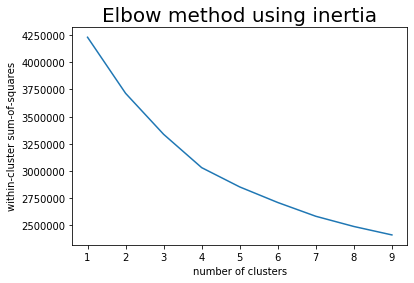

In [9]:
%matplotlib inline
plt.plot(np.arange(1,10), distance)
plt.title('Elbow method using inertia', fontsize=20)
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum-of-squares')

In [10]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
#https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
for i in range(1,20):
    kmeans = KMeans(i)
    kmeans.fit(X_scale)
    distortions.append(sum(np.min(cdist(X_scale, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_scale.shape[0])

Text(0, 0.5, 'distortion')

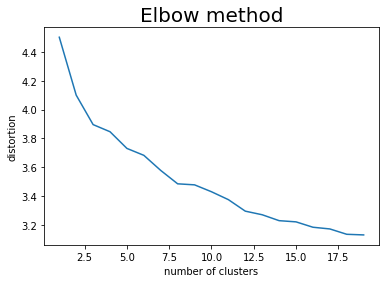

In [11]:
plt.plot(np.arange(1,20), distortions)
plt.title('Elbow method', fontsize=20)
plt.xlabel('number of clusters')
plt.ylabel('distortion')

In [8]:
# applying PCA
pca = PCA(n_components=15)
pca.fit(X_scale)
X_pca = pca.transform(X_scale)
print('Shape of 15 components of PCA: {}' .format(X_pca.shape))

Shape of 15 components of PCA: (141020, 15)


In [14]:
# finding the optimal clusters by elbow method without PCA

dist = []
for i in range(1,10):
    kmeans_ = KMeans(i)
    kmeans_.fit(X_pca)
    dist.append(kmeans_.inertia_)
    

Text(0, 0.5, 'within-cluster sum-of-squares')

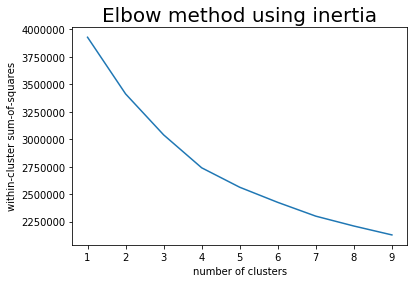

In [15]:
plt.plot(np.arange(1,10), dist)
plt.title('Elbow method using inertia', fontsize=20)
plt.xlabel('number of clusters')
plt.ylabel('within-cluster sum-of-squares')

In [9]:
# finding the optimal clusters by gap statistic method
def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [10]:
k, gapdf = optimalK(X_pca, nrefs=3, maxClusters=10)
print('Optimal k is: ', k)

Optimal k is:  9


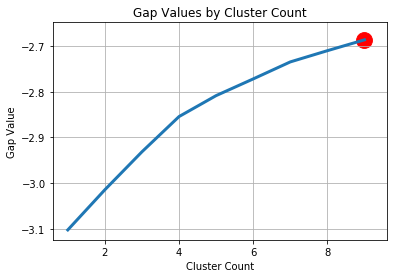

In [11]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [31]:
# computing two clusteres 
model = KMeans(n_clusters=2, random_state=1)
model.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

Text(0, 0.5, 'Principal component 1')

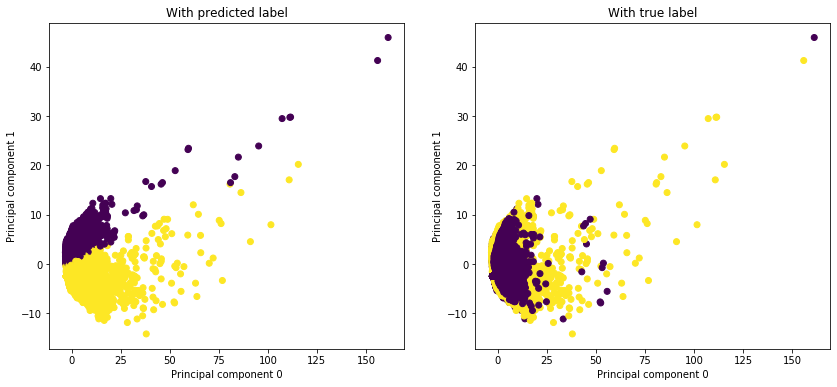

In [32]:
plt.figure(figsize=(14,6))
plt.subplot((121))
plt.scatter(X_pca[:,0], X_pca[:,1], c=model.labels_ )
plt.title('With predicted label')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 1')
plt.subplot((122))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y )
plt.title('With true label')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 1')

Text(0, 0.5, 'Principal component 2')

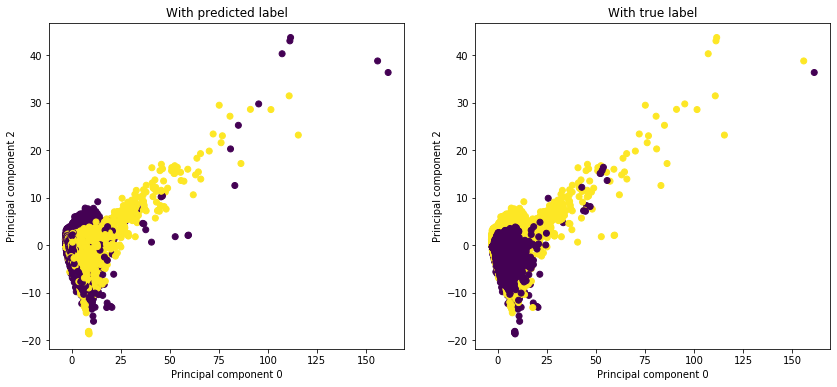

In [33]:
plt.figure(figsize=(14,6))
plt.subplot((121))
plt.scatter(X_pca[:,0], X_pca[:,2], c=model.labels_ )
plt.title('With predicted label')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 2')
plt.subplot((122))
plt.scatter(X_pca[:,0], X_pca[:,2], c=y )
plt.title('With true label')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 3')

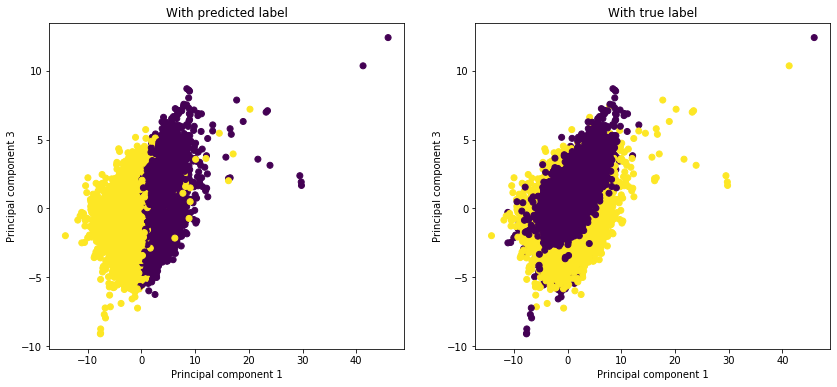

In [34]:
plt.figure(figsize=(14,6))
plt.subplot((121))
plt.scatter(X_pca[:,1], X_pca[:,3], c=model.labels_ )
plt.title('With predicted label')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')
plt.subplot((122))
plt.scatter(X_pca[:,1], X_pca[:,3], c=y )
plt.title('With true label')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 3')

In [35]:
# contingency matrix of predicted labels
pd.crosstab(index=0, columns=model.labels_)

col_0      0      1
row_0              
0      59460  81560

In [36]:
# contingency matrix of true labels
pd.crosstab(index=0, columns=y)

label    0.0    1.0
row_0              
0      48804  92216

In [37]:
# computing 4 clusters
model = KMeans(n_clusters=4, random_state=1) # for 4 clusters
model.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [38]:
# contingency matrix of true and predicted labels with four clusters
pd.crosstab(index=y, columns=model.labels_)

col_0      0      1    2      3
label                          
0.0     7856  15900   15  25033
1.0    13095  30934  143  48044